<a href="https://colab.research.google.com/github/UTDataMining/2022A/blob/main/lab11/Intro_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchによるニューラルネットワークの実装
[Pytorch](https://pytorch.org/)

In [2]:
import autograd.numpy as np
from autograd import grad
import torch

## Autograd
シグモイド関数の勾配計算

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

$$
\frac{\partial f}{\partial x} = f(x)(1-f(x))
$$


In [3]:
def sigmoid(x): # 関数定義
  return 1.0/(1.0 + np.exp(-x))

In [4]:
def grad_sigmoid_symbolic(x):
    s = sigmoid(x)
    dsdx = s * (1 - s)
    return dsdx
grad_sigmoid_symbolic(1.0) # 勾配の値（x=1.0における）

0.19661193324148185

Autograd（自動微分）によるシグモイド関数の勾配計算

[Autograd](https://github.com/HIPS/autograd)

[Autogradチュートリアル](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md)


シグモイド関数を以下のような単純な関数の組み合わせで考える。

$$f(x) = s(c(b(a(x))))$$

$$
a(x) = -x
$$

$$
b(a) = e^a
$$

$$
c(b) = 1 + b
$$

$$
s(c) = \frac{1}{c}
$$

この時の計算グラフは以下のように表すことができる。
 
![Gradient Computation Image](https://drive.google.com/uc?export=view&id=1bvdPv0MI2eM3GeobsHFsFjLrLsibuhJa)

連鎖律を用いて入力$x$に関する関数$s$の勾配$\frac{\partial s}{\partial x}$は
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x}
$$
となります。この勾配を実際に求めてみると以下のようになります。

In [5]:
def grad_sigmoid_manual(x):
    a = -x        
    b = np.exp(a) 
    c = 1 + b     
    s = 1.0 / c   
    
    dsdc = (-1.0 / (c**2))
    dsdb = dsdc * 1
    dsda = dsdb * np.exp(a)
    dsdx = dsda * (-1)
    
    return dsdx

grad_sigmoid_manual(1.0) # 勾配の値（x=1.0における）

0.19661193324148188

上記の手続きをAutogradで記述すると以下のようになります。

In [6]:
grad_sigmoid = grad(sigmoid) # 勾配の取得　
grad_sigmoid(1.0) # 勾配の値（x=1.0における）

0.19661193324148188

有限差分による勾配を確認してみましょう。

In [ ]:
(sigmoid(1.0001) - sigmoid(0.9999)) / 0.0002 # 有限差分による勾配の確認

0.19661193318254444

## PyTorchによるAutomatic differentiation
[Autograd](https://pytorch.org/docs/stable/notes/autograd.html)


In [7]:
def f(x): # 関数定義 
    return 1.0/(1.0+torch.exp(-x))

x = torch.from_numpy(np.array([1.0])).requires_grad_(True)
# x = torch.tensor(1.0).requires_grad_(True) 
y = f(x)
y.backward() # 勾配の計算
x.grad.item()

0.19661193324148188

## PyTorchによるロジスティック回帰の実装
課題9で実装したロジスティック回帰をPyTorchで実装

In [9]:
import numpy as np
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/UTDataMining/2022A/master/ex8/iris.csv')
X=iris[(iris['species']=='versicolor')| (iris['species']=='virginica')][['petal_length', 'petal_width']].values
y=iris[(iris['species']=='versicolor')| (iris['species']=='virginica')][['species']].values
y = (y=='versicolor').astype(int)
X = (X-np.mean(X, axis=0))/np.std(X, axis=0)
m = X.shape[0]
n = X.shape[1]
X = torch.from_numpy(X).to(torch.float)
y = torch.from_numpy(y).to(torch.float)

In [16]:
num_epochs = 100  # エポック数
alpha = 0.1  # 学習率

### その1
- 損失関数の勾配を自動微分で計算

In [13]:
w = torch.zeros(n,1).requires_grad_(True) # パラメータ
b = torch.zeros(1).requires_grad_(True) # バイアス
for i in range(num_epochs):
    f = torch.mm(X,w)+b # torch.matmul(X,w)+b, X@w+b
    g = 1/(1+torch.exp(-f))
    loss =  (-1 / m) * torch.sum(y*torch.log(g)+(1-y)*torch.log(1-g))
    loss.backward()
    with torch.no_grad():
        w.data = w - alpha * w.grad # w -= alpha * w.grad
        b.data = b  - alpha * b.grad # b -= alpha * b.grad
        w.grad.zero_()
        b.grad.zero_()
print(w.detach().cpu().numpy())
print(b.detach().cpu().numpy())
print(loss.item()) # コスト

[[-1.2888526]
 [-1.4116936]]
[-0.02318852]
0.19912464916706085


### その2
- PyTorchを使ってパラメータ最適化（確率的勾配降下法）
  - [optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [17]:
w = torch.zeros(n,1).requires_grad_(True) # パラメータ
b = torch.zeros(1).requires_grad_(True) # バイアス
optimizer = torch.optim.SGD([w, b], lr=alpha) # SGD: 確率的勾配降下法
for epoch in range(num_epochs):
    f = torch.mm(X, w) + b
    g = torch.sigmoid(f)
    loss =  (-1 / m) * torch.sum(y*torch.log(g)+(1-y)*torch.log(1-g))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(w.detach().cpu().numpy())
print(b.detach().cpu().numpy())
print(loss.item())

[[-1.2888526]
 [-1.4116936]]
[-0.02318852]
0.19912464916706085


### その3
- PyTorchを使ってモデルを作成（`nn.Sequential`）
  - [nn.Sequantial](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

In [20]:
model = torch.nn.Sequential()
linear = torch.nn.Linear(n, 1) # 線形層 n -> 1
torch.nn.init.zeros_(linear.weight) # パラメータ初期化
torch.nn.init.zeros_(linear.bias) # バイアス初期化
model.add_module('linear', linear) 
model.add_module('simoid', torch.nn.Sigmoid()) # シグモイド関数
cost = torch.nn.BCELoss() # バイナリー交差エントロピー誤差
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)
for i in range(num_epochs):
    loss = cost(model(X), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
for param in model.parameters():
  print(param.detach().cpu().numpy())
print(loss.item())

[[-1.2888526 -1.4116936]]
[-0.02318852]
0.19912463426589966


### その4
- PyTorchを使ってモデルを作成（`nn.Module`）
   - [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

In [21]:
class MyModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1) # 線形層 n -> 1
        torch.nn.init.zeros_(self.linear.weight)
        torch.nn.init.zeros_(self.linear.bias)
    def forward(self, x):
        return torch.sigmoid(self.linear(x)) # シグモイド関数

In [23]:
model = MyModel(n)
cost = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)
for i in range(num_epochs):  
    loss = cost(model(X), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
for param in model.parameters():
  print(param.detach().cpu().numpy())
print(loss.item())

[[-1.2888526 -1.4116936]]
[-0.02318852]
0.19912463426589966


## マルチレイヤーパーセプトロンの実装（手書き数字画像認識の例）

実行の前にメニューの

ランタイム -> ランタイムのタイプの変更　

でハードウェアアクセラレータをGPUにしてください

In [24]:
# グラフを動的に可視化するモジュール
!pip install livelossplot 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from livelossplot import PlotLosses

In [26]:
# データセット
mnist_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



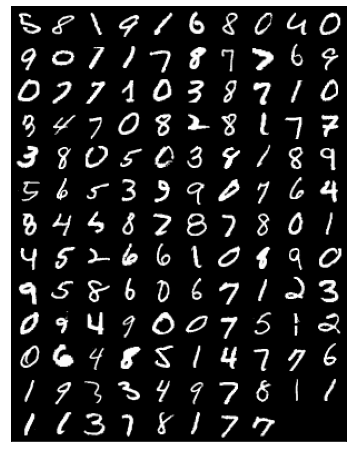

In [27]:
train_bs = 128 # 訓練データのバッチサイズ
test_bs = 100 # テストデータのバッチサイズ

# データローダ
train_dl = DataLoader(mnist_train, batch_size = train_bs, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size = test_bs)

dataiter = iter(train_dl)
images, labels = next(dataiter)
viz = torchvision.utils.make_grid(images, nrow=10, padding = 2).numpy()
fig, ax = plt.subplots(figsize= (8,8))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [28]:
# ネットワーク定義
dim_x = 784 # 入力層のユニット数（28x28のピクセル）
dim_h = 100 # 隠れ層のユニット数
dim_out = 10 # 出力層のユニット数（クラス数）

model = torch.nn.Sequential()
model.add_module('fc1', torch.nn.Linear(dim_x, dim_h)) # 入力層-隠れ層
model.add_module('relu1', torch.nn.ReLU()) # 活性関数ReLU
#model.add_module('dropout1',torch.nn.Dropout()) # ドロップアウト
model.add_module('fc2', torch.nn.Linear(dim_h, dim_out)) # 隠れ層-出力層
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


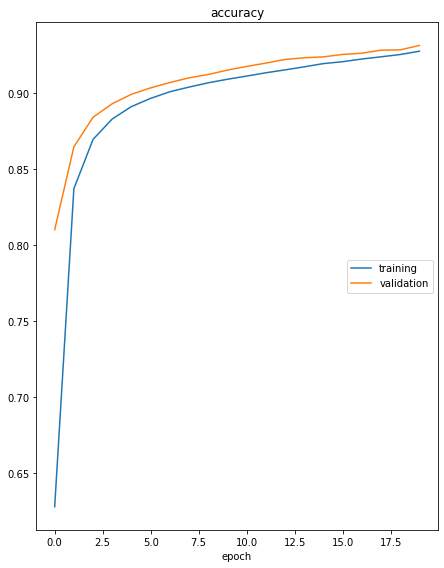

accuracy
	training         	 (min:    0.628, max:    0.927, cur:    0.927)
	validation       	 (min:    0.810, max:    0.931, cur:    0.931)


In [29]:
# GPUsの使用
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"

learning_rate = 1e-2 # 学習率
epochs = 20 # エポック数

# 最適化法（SGD）
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss() # 損失関数
model.to(device) # モデルをGPUへ
model.train() # 訓練モード
liveloss = PlotLosses() # グラフ可視化

# エポック数繰り返し
for epoch in range(epochs):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    model.train() # 訓練モード
    for i, (X_train, y_train) in enumerate(train_dl):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_train = X_train.view(X_train.size(0), -1)
        
        # forward
        y_pred = model(X_train) 
        loss = loss_fn(y_pred, y_train) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_train).float().mean()       
        train_loss.append(loss.item())
        train_acc.append(acc.item())

        # backward 
        model.zero_grad() # またはoptimizer.zero_grad() 勾配初期化
        loss.backward() # 勾配計算
        optimizer.step() # パラメータ更新
    
    model.eval() # 評価モード    
    for i, (X_test, y_test) in enumerate(test_dl):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        X_test = X_test.view(X_test.size(0), -1)
        y_pred = model(X_test) 
        loss = loss_fn(y_pred, y_test) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_test).float().mean() # 精度        
        test_loss.append(loss.item())
        test_acc.append(acc.item())
    
    #print(epoch+1, np.array(train_loss).mean(), np.array(train_acc).mean()) # 訓練誤差
    #print(epoch+1, np.array(test_loss).mean(), np.array(test_acc).mean()) # テスト誤差
    
    liveloss.update({
        'accuracy': np.array(train_acc).mean(),
        'val_accuracy': np.array(test_acc).mean()
    })
    liveloss.draw()

### モデル選択

In [30]:
# ネットワークの定義
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_func=torch.nn.functional.relu):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim) # 入力層-隠れ層1
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)  # 隠れ層1-隠れ層2
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)  # 隠れ層2-出力層
        self.activation_func = activation_func # 活性化関数
    
    def forward(self, x):
        h1 = self.activation_func(self.fc1(x))
        h2 = self.activation_func(self.fc2(h1))
        out = self.fc3(h2)
        return out

In [31]:
# モデル訓練
def train_model(model, optimizer, train_loader, test_loader, epochs=10):
  if torch.cuda.is_available():
      print("Using cuda")
      use_cuda = True
      device = torch.device("cuda")
  else:
      device = "cpu"

  loss_fn = torch.nn.CrossEntropyLoss()
  model.to(device)    
  model.train()
  liveloss = PlotLosses()
  
  for epoch in range(epochs):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    model.train() # 訓練モード
    for i, (X_train, y_train) in enumerate(train_dl):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_train = X_train.view(X_train.size(0), -1)
        
        # forward
        y_pred = model(X_train) 
        loss = loss_fn(y_pred, y_train) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_train).float().mean()
        train_loss.append(loss.item())
        train_acc.append(acc.item())

        # backward 
        model.zero_grad() # またはoptimizer.zero_grad() 勾配初期化
        loss.backward() # 勾配計算
        optimizer.step() # パラメータ更新
    
    model.eval() # 評価モード
    for i, (X_test, y_test) in enumerate(test_dl):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        X_test = X_test.view(X_test.size(0), -1)

        y_pred = model(X_test) 
        loss = loss_fn(y_pred, y_test) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_test).float().mean()
        test_loss.append(loss.item())
        test_acc.append(acc.item())
    
    #print(epoch+1, np.array(train_loss).mean(), np.array(train_acc).mean()) # 訓練誤差
    #print(epoch+1, np.array(test_loss).mean(), np.array(test_acc).mean()) # テスト誤差
    
    liveloss.update({
        'accuracy': np.array(train_acc).mean(),
        'val_accuracy': np.array(test_acc).mean()
    })
    liveloss.draw()

In [32]:
# パラメータ初期化方法
def init_weights_xavier(m): #
  if type(m) == torch.nn.Linear:
    torch.nn.init.xavier_normal_(m.weight)

def init_weights_kaiminghe(m): # 
  if type(m) == torch.nn.Linear:
    torch.nn.init.kaiming_normal_(m.weight)

以下を変更してみてください
- 隠れ層のユニット数
- 隠れ層の数
- 活性化関数 [functional](https://pytorch.org/docs/stable/nn.functional.html)
- パラメータの初期化方法 [init](https://pytorch.org/docs/stable/nn.init.html)
- 最適化方法 [optim](https://pytorch.org/docs/stable/optim.html)
- 学習率
- エポック数

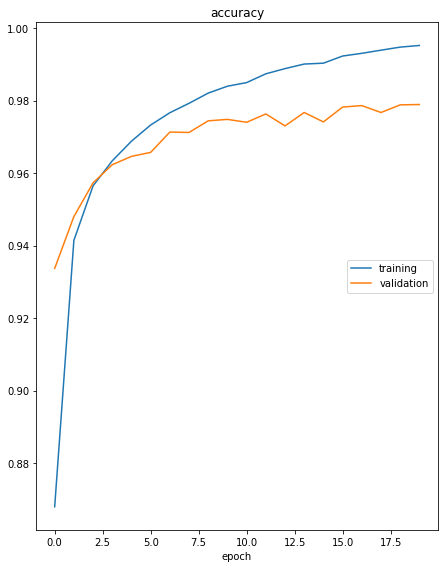

accuracy
	training         	 (min:    0.868, max:    0.995, cur:    0.995)
	validation       	 (min:    0.934, max:    0.979, cur:    0.979)


In [33]:
train_bs = 128 # 訓練データのバッチサイズ
test_bs = 100 # テストデータのバッチサイズ
train_dl = DataLoader(mnist_train, batch_size = train_bs, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size =test_bs)

dim_x = 784 # 入力層のユニット数（28x28の画像）
dim_h = 100 # 隠れ層のユニット数
dim_out = 10 # 出力層のユニット数（クラス数）

# 活性化関数
activation_func = torch.nn.functional.relu
model = Net(dim_x, dim_h, dim_out, activation_func)

# パラメータ初期化
model = model.apply(init_weights_kaiminghe)

# 最適化法
params = model.parameters()
learning_rate = 0.01 # 学習率
momentum = 0.9 # モーメンタム
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum)
#optimizer = torch.optim.RMSprop(params, learning_rate)
#optimizer = torch.optim.Adam(params, learning_rate)

epochs = 20 # エポック数  
train_model(model, optimizer, train_dl, test_dl, epochs=epochs)